DEMAND FORECASTING MODEL

In [1]:
# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================
import pandas as pd
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

from prophet import Prophet

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
    dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

    # Access the 'train' split and convert to pandas
    df = dataset['train'].to_pandas()

README.md: 0.00B [00:00, ?B/s]

data/train.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

data/eval.parquet:   0%|          | 0.00/8.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4500000 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/350000 [00:00<?, ? examples/s]

In [ ]:
print(df.head())

   city_id  store_id  management_group_id  first_category_id  \
0        0         0                    0                  5   
1        0         0                    0                  5   
2        0         0                    0                  5   
3        0         0                    0                  5   
4        0         0                    0                  5   

   second_category_id  third_category_id  product_id          dt  sale_amount  \
0                   6                 65          38  2024-03-28          0.1   
1                   6                 65          38  2024-03-29          0.1   
2                   6                 65          38  2024-03-30          0.0   
3                   6                 65          38  2024-03-31          0.1   
4                   6                 65          38  2024-04-01          0.2   

                                          hours_sale  stock_hour6_22_cnt  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, ...

In [3]:
df.describe()

,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,sale_amount,stock_hour6_22_cnt,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
count,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06,4.500000e+06
mean,4.974420e+00,4.090807e+02,4.621640e+00,1.521366e+01,4.473508e+01,1.163621e+02,3.904260e+02,9.985913e-01,3.180341e+00,9.111412e-01,3.444444e-01,3.784207e-01,3.698385e+00,2.227911e+01,7.445046e+01,1.724542e+00
std,6.096600e+00,2.485456e+02,1.962418e+00,8.972127e+00,2.233890e+01,5.756037e+01,2.634697e+02,1.406738e+00,4.596586e+00,1.281734e-01,4.751868e-01,4.849933e-01,3.683960e+00,3.593264e+00,1.009831e+01,3.845731e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.206000e+01,2.735000e+01,9.700000e-01
25%,0.000000e+00,1.950000e+02,3.000000e+00,5.000000e+00,2.800000e+01,7.700000e+01,1.350000e+02,4.000000e-01,0.000000e+00,8.510000e-01,0.000000e+00,0.000000e+00,1.428800e+00,1.939000e+01,7.162000e+01,1.450000e+00
50%,0.000000e+00,3.950000e+02,6.000000e+00,1.600000e+01,3.800000e+01,1.110000e+02,3.630000e+02,7.000000e-01,0.000000e+00,9.890000e-01,0.000000e+00,0.000000e+00,2.297700e+00,2.250000e+01,7.636000e+01,1.640000e+00
75%,1.200000e+01,5.980000e+02,6.000000e+00,2.100000e+01,6.600000e+01,1.670000e+02,6.330000e+02,1.100000e+00,6.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.481600e+00,2.540000e+01,8.071000e+01,1.950000e+00
max,1.700000e+01,8.970000e+02,6.000000e+00,3.100000e+01,8.300000e+01,2.320000e+02,8.640000e+02,4.490000e+01,1.600000e+01,1.088000e+00,1.000000e+00,1.000000e+00,4.250000e+01,3.088000e+01,1.000000e+02,3.850000e+00


In [4]:
df.shape

(4500000, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500000 entries, 0 to 4499999
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   city_id              int64  
 1   store_id             int64  
 2   management_group_id  int64  
 3   first_category_id    int64  
 4   second_category_id   int64  
 5   third_category_id    int64  
 6   product_id           int64  
 7   dt                   object 
 8   sale_amount          float64
 9   hours_sale           object 
 10  stock_hour6_22_cnt   int32  
 11  hours_stock_status   object 
 12  discount             float64
 13  holiday_flag         int32  
 14  activity_flag        int32  
 15  precpt               float64
 16  avg_temperature      float64
 17  avg_humidity         float64
 18  avg_wind_level       float64
dtypes: float64(6), int32(3), int64(7), object(3)
memory usage: 600.8+ MB


In [12]:
# ============================================================================
# 2. LOAD AND EXPLORE DATA
# ============================================================================
def load_data():
    """Load the FreshRetailNet dataset"""
    from datasets import load_dataset

    print("Loading dataset...")
    dataset = load_dataset("Dingdong-Inc/FreshRetailNet-50K")

    # Access the 'train' split and convert to pandas
    df = dataset['train'].to_pandas()

    print(f"✓ Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"  Note: Using 'train' split from dataset. Will perform time-based split later.")

    return df

def explore_data(df):
    """Perform initial data exploration"""
    print("\n" + "="*80)
    print("DATA EXPLORATION")
    print("="*80)

    print("\n1. Dataset Shape:")
    print(f"   Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")

    print("\n2. Column Names and Types:")
    print(df.dtypes)

    print("\n3. Missing Values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("   No missing values!")

    print("\n4. Basic Statistics:")
    print(df['sale_amount'].describe())

    print("\n5. Date Range:")
    print(f"   From: {df['dt'].min()} | To: {df['dt'].max()}")

    print("\n6. Unique SKUs (Products):")
    print(f"   Total Products: {df['product_id'].nunique()}")
    print(f"   Total Stores: {df['store_id'].nunique()}")

    return df

In [13]:
# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================
def preprocess_data(df):
    """Clean and prepare the data"""
    print("\n" + "="*80)
    print("DATA PREPROCESSING")
    print("="*80)

    df = df.copy()

    # Convert date column
    df['dt'] = pd.to_datetime(df['dt'])
    print("✓ Date column converted")

    # Sort by date
    df = df.sort_values(['store_id', 'product_id', 'dt']).reset_index(drop=True)
    print("✓ Data sorted by store, product, and date")

    # Handle missing values in sale_amount
    df['sale_amount'] = df['sale_amount'].fillna(0)
    print("✓ Missing values handled")

    return df

In [14]:
# ============================================================================
# 4. FEATURE ENGINEERING
# ============================================================================
def create_temporal_features(df):
    """Create time-based features"""
    print("\n" + "="*80)
    print("FEATURE ENGINEERING - TEMPORAL FEATURES")
    print("="*80)

    df = df.copy()

    # Basic temporal features
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['day'] = df['dt'].dt.day
    df['day_of_week'] = df['dt'].dt.dayofweek
    df['day_of_year'] = df['dt'].dt.dayofyear
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    df['quarter'] = df['dt'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['dt'].dt.is_month_end.astype(int)

    print("✓ Created 11 temporal features")

    return df

def create_lag_features(df, lags=[1, 7, 14, 30]):
    """Create lag features for sale_amount"""
    print("\n" + "="*80)
    print("FEATURE ENGINEERING - LAG FEATURES")
    print("="*80)

    df = df.copy()

    for lag in lags:
        df[f'sale_lag_{lag}'] = df.groupby(['store_id', 'product_id'])['sale_amount'].shift(lag)

    print(f"✓ Created {len(lags)} lag features: {lags}")

    return df

def create_rolling_features(df, windows=[7, 14, 30]):
    """Create rolling window features"""
    print("\n" + "="*80)
    print("FEATURE ENGINEERING - ROLLING FEATURES")
    print("="*80)

    df = df.copy()

    for window in windows:
        # Rolling mean
        df[f'sale_rolling_mean_{window}'] = df.groupby(['store_id', 'product_id'])['sale_amount'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )

        # Rolling std
        df[f'sale_rolling_std_{window}'] = df.groupby(['store_id', 'product_id'])['sale_amount'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )

        # Rolling max
        df[f'sale_rolling_max_{window}'] = df.groupby(['store_id', 'product_id'])['sale_amount'].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )

        # Rolling min
        df[f'sale_rolling_min_{window}'] = df.groupby(['store_id', 'product_id'])['sale_amount'].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )

    print(f"✓ Created {len(windows) * 4} rolling features for windows: {windows}")

    return df

def create_aggregated_features(df):
    """Create aggregated features at product and store level"""
    print("\n" + "="*80)
    print("FEATURE ENGINEERING - AGGREGATED FEATURES")
    print("="*80)

    df = df.copy()

    # Product-level features
    product_stats = df.groupby('product_id')['sale_amount'].agg([
        ('product_mean_sale', 'mean'),
        ('product_std_sale', 'std'),
        ('product_max_sale', 'max')
    ]).reset_index()

    df = df.merge(product_stats, on='product_id', how='left')
    print("✓ Created 3 product-level features")

    # Store-level features
    store_stats = df.groupby('store_id')['sale_amount'].agg([
        ('store_mean_sale', 'mean'),
        ('store_std_sale', 'std')
    ]).reset_index()

    df = df.merge(store_stats, on='store_id', how='left')
    print("✓ Created 2 store-level features")

    # Store-Product interaction
    df['store_product_interaction'] = df.groupby(['store_id', 'product_id'])['sale_amount'].transform('mean')
    print("✓ Created store-product interaction feature")

    return df

def engineer_all_features(df):
    """Apply all feature engineering steps"""
    print("\n" + "="*80)
    print("APPLYING ALL FEATURE ENGINEERING")
    print("="*80)

    # Apply feature engineering
    df = create_temporal_features(df)
    df = create_lag_features(df)
    df = create_rolling_features(df)
    df = create_aggregated_features(df)

    # Drop rows with NaN values created by lag features
    initial_rows = len(df)
    df = df.dropna()
    dropped_rows = initial_rows - len(df)

    print(f"\n✓ Feature engineering complete!")
    print(f"  Dropped {dropped_rows:,} rows with NaN values")
    print(f"  Final dataset: {len(df):,} rows, {len(df.columns)} columns")

    return df

In [15]:
# ============================================================================
# 5. PREPARE TRAINING DATA
# ============================================================================
def prepare_train_test_split(df, test_size=0.2):
    """Prepare train and test datasets using time-based split"""
    print("\n" + "="*80)
    print("PREPARING TRAIN-TEST SPLIT (TIME-BASED)")
    print("="*80)

    # Define features to exclude
    exclude_cols = ['dt', 'sale_amount', 'hours_sale', 'hours_stock_status']

    # Select feature columns (only those that exist in the dataframe)
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    X = df[feature_cols]
    y = df['sale_amount']

    # Time-based split (CRITICAL for time series!)
    # We use the ENTIRE 'train' split from the dataset and create our own split
    # This prevents data leakage and maintains temporal order
    split_date = df['dt'].quantile(1 - test_size)
    train_mask = df['dt'] <= split_date

    X_train = X[train_mask]
    X_test = X[~train_mask]
    y_train = y[train_mask]
    y_test = y[~train_mask]

    # Calculate split date info
    train_start = df.loc[train_mask, 'dt'].min()
    train_end = df.loc[train_mask, 'dt'].max()
    test_start = df.loc[~train_mask, 'dt'].min()
    test_end = df.loc[~train_mask, 'dt'].max()

    print(f"✓ Train set: {len(X_train):,} samples")
    print(f"  Date range: {train_start} to {train_end}")
    print(f"✓ Test set: {len(X_test):,} samples")
    print(f"  Date range: {test_start} to {test_end}")
    print(f"✓ Number of features: {len(feature_cols)}")

    print(f"\n📊 Feature categories:")
    print(f"  - Temporal: year, month, day, day_of_week, quarter, etc.")
    print(f"  - Lag: sale_lag_1, sale_lag_7, sale_lag_14, sale_lag_30")
    print(f"  - Rolling: rolling_mean, rolling_std, rolling_max, rolling_min")
    print(f"  - Aggregated: product_mean_sale, store_mean_sale, etc.")
    print(f"  - External: weather (precpt, avg_temperature, avg_humidity, avg_wind_level)")
    print(f"  - Categorical: holiday_flag, activity_flag, discount, stock info")

    return X_train, X_test, y_train, y_test, feature_cols, df[~train_mask]

In [16]:
# ============================================================================
# 6. MODEL TRAINING
# ============================================================================
def train_lightgbm(X_train, y_train, X_test, y_test):
    """Train LightGBM model"""
    print("\n" + "="*80)
    print("TRAINING LIGHTGBM MODEL")
    print("="*80)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'n_estimators': 1000,
        'random_state': 42
    }

    model = lgb.LGBMRegressor(**params)

    print("Training model...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    print("✓ Model training complete!")

    return model

def train_xgboost(X_train, y_train, X_test, y_test):
    """Train XGBoost model"""
    print("\n" + "="*80)
    print("TRAINING XGBOOST MODEL")
    print("="*80)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.05,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42
    }

    model = xgb.XGBRegressor(**params)

    print("Training model...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        # Removed early_stopping_rounds
        verbose=False # Keep verbose for potential progress output
    )

    print("✓ Model training complete!")

    return model

def train_random_forest(X_train, y_train):
    """Train Random Forest model"""
    print("\n" + "="*80)
    print("TRAINING RANDOM FOREST MODEL")
    print("="*80)

    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    print("Training model...")
    model.fit(X_train, y_train)

    print("✓ Model training complete!")

    return model

In [17]:
# ============================================================================
# 7. MODEL EVALUATION
# ============================================================================
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate model performance"""
    print("\n" + "="*80)
    print(f"EVALUATING {model_name}")
    print("="*80)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    def mape(y_true, y_pred):
        mask = y_true > 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    test_mape = mape(y_test.values, y_test_pred)

    print(f"\n{'Metric':<20} {'Train':<15} {'Test':<15}")
    print("-" * 50)
    print(f"{'MAE':<20} {train_mae:<15.4f} {test_mae:<15.4f}")
    print(f"{'RMSE':<20} {train_rmse:<15.4f} {test_rmse:<15.4f}")
    print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
    print(f"{'MAPE (%)':<20} {'-':<15} {test_mape:<15.2f}")

    metrics = {
        'model_name': model_name,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mape': test_mape
    }

    return metrics, y_test_pred

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# ============================================================================
# 8. VISUALIZATION
# ============================================================================
def plot_feature_importance(model, feature_cols, model_name, top_n=20):
    """Plot feature importance"""
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)

        plt.figure(figsize=(12, 8))
        sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
        plt.title(f'Top {top_n} Feature Importance - {model_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Importance', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.show()

def plot_predictions(y_test, y_pred, model_name):
    """Plot actual vs predicted values"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot
    axes[0].scatter(y_test, y_pred, alpha=0.5, s=10)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Sales', fontsize=12)
    axes[0].set_ylabel('Predicted Sales', fontsize=12)
    axes[0].set_title(f'Actual vs Predicted - {model_name}', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residual plot
    residuals = y_test.values - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Sales', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_title(f'Residual Plot - {model_name}', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_time_series_forecast(df, y_test, y_pred, product_id, store_id):
    """Plot time series forecast for a specific SKU"""
    # Get test data for specific SKU
    test_mask = (df['product_id'] == product_id) & (df['store_id'] == store_id)
    sku_data = df[test_mask].copy()

    if len(sku_data) > 0:
        # Align predictions with dates
        sku_data = sku_data.tail(len(y_pred))
        sku_data['predicted'] = y_pred[:len(sku_data)]

        plt.figure(figsize=(14, 6))
        plt.plot(sku_data['dt'], sku_data['sale_amount'],
                label='Actual', marker='o', markersize=4, linewidth=2)
        plt.plot(sku_data['dt'], sku_data['predicted'],
                label='Predicted', marker='s', markersize=4, linewidth=2)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sales Amount', fontsize=12)
        plt.title(f'Demand Forecast - Product {product_id}, Store {store_id}',
                 fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
# ============================================================================
# 9. SAVE MODEL
# ============================================================================
def save_model(model, filepath, feature_cols):
    """Save trained model"""
    import pickle

    model_package = {
        'model': model,
        'feature_cols': feature_cols,
        'model_type': type(model).__name__
    }

    with open(filepath, 'wb') as f:
        pickle.dump(model_package, f)

    print(f"✓ Model saved to: {filepath}")

In [ ]:
# ============================================================================
# 10. MAIN EXECUTION PIPELINE
# ============================================================================

In [ ]:
# Load data
df = load_data()

Loading dataset...
✓ Dataset loaded: 4500000 rows, 19 columns
  Note: Using 'train' split from dataset. Will perform time-based split later.


In [ ]:
# Explore data
df = explore_data(df)


DATA EXPLORATION

1. Dataset Shape:
   Rows: 4,500,000 | Columns: 19

2. Column Names and Types:
city_id                  int64
store_id                 int64
management_group_id      int64
first_category_id        int64
second_category_id       int64
third_category_id        int64
product_id               int64
dt                      object
sale_amount            float64
hours_sale              object
stock_hour6_22_cnt       int32
hours_stock_status      object
discount               float64
holiday_flag             int32
activity_flag            int32
precpt                 float64
avg_temperature        float64
avg_humidity           float64
avg_wind_level         float64
dtype: object

3. Missing Values:
   No missing values!

4. Basic Statistics:
count    4.500000e+06
mean     9.985913e-01
std      1.406738e+00
min      0.000000e+00
25%      4.000000e-01
50%      7.000000e-01
75%      1.100000e+00
max      4.490000e+01
Name: sale_amount, dtype: float64

5. Date Range:
   From: 

In [ ]:
# Preprocess
df = preprocess_data(df)


DATA PREPROCESSING
✓ Date column converted
✓ Data sorted by store, product, and date
✓ Missing values handled


In [ ]:
# Feature engineering
df = engineer_all_features(df)


APPLYING ALL FEATURE ENGINEERING

FEATURE ENGINEERING - TEMPORAL FEATURES
✓ Created 11 temporal features

FEATURE ENGINEERING - LAG FEATURES
✓ Created 4 lag features: [1, 7, 14, 30]

FEATURE ENGINEERING - ROLLING FEATURES
✓ Created 12 rolling features for windows: [7, 14, 30]

FEATURE ENGINEERING - AGGREGATED FEATURES
✓ Created 3 product-level features
✓ Created 2 store-level features
✓ Created store-product interaction feature

✓ Feature engineering complete!
  Dropped 1,500,000 rows with NaN values
  Final dataset: 3,000,000 rows, 51 columns


In [ ]:
# Prepare train-test split
X_train, X_test, y_train, y_test, feature_cols, test_df = prepare_train_test_split(df)


PREPARING TRAIN-TEST SPLIT (TIME-BASED)
✓ Train set: 2,400,000 samples
  Date range: 2024-04-27 00:00:00 to 2024-06-13 00:00:00
✓ Test set: 600,000 samples
  Date range: 2024-06-14 00:00:00 to 2024-06-25 00:00:00
✓ Number of features: 47

📊 Feature categories:
  - Temporal: year, month, day, day_of_week, quarter, etc.
  - Lag: sale_lag_1, sale_lag_7, sale_lag_14, sale_lag_30
  - Rolling: rolling_mean, rolling_std, rolling_max, rolling_min
  - Aggregated: product_mean_sale, store_mean_sale, etc.
  - External: weather (precpt, avg_temperature, avg_humidity, avg_wind_level)
  - Categorical: holiday_flag, activity_flag, discount, stock info


In [ ]:
# Train models
print("\n" + "="*80)
print("MODEL TRAINING PHASE")
print("="*80)

# Train LightGBM (recommended for large datasets)
lgb_model = train_lightgbm(X_train, y_train, X_test, y_test)
lgb_metrics, lgb_pred = evaluate_model(lgb_model, X_train, y_train,
                                        X_test, y_test, "LightGBM")


MODEL TRAINING PHASE

TRAINING LIGHTGBM MODEL
Training model...
✓ Model training complete!

EVALUATING LightGBM

Metric               Train           Test           
--------------------------------------------------
MAE                  0.2307          0.2694         
RMSE                 0.3432          0.4377         
R² Score             0.9482          0.9396         
MAPE (%)             -               36.20          


In [ ]:
# Train XGBoost
# The train_xgboost function is defined in cell 3aE-6bo0wYHk
xgb_model = train_xgboost(X_train, y_train, X_test, y_test)
xgb_metrics, xgb_pred = evaluate_model(xgb_model, X_train, y_train,
                                        X_test, y_test, "XGBoost")


TRAINING XGBOOST MODEL
Training model...
✓ Model training complete!

EVALUATING XGBoost

Metric               Train           Test           
--------------------------------------------------
MAE                  0.2187          0.2684         
RMSE                 0.3208          0.4611         
R² Score             0.9547          0.9329         
MAPE (%)             -               35.29          


In [ ]:
# Compare models
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

comparison_df = pd.DataFrame([lgb_metrics, xgb_metrics])
print(comparison_df[['model_name', 'test_mae', 'test_rmse', 'test_r2', 'test_mape']])

# Select best model
best_model = lgb_model if lgb_metrics['test_mae'] < xgb_metrics['test_mae'] else xgb_model
best_name = "LightGBM" if lgb_metrics['test_mae'] < xgb_metrics['test_mae'] else "XGBoost"
best_pred = lgb_pred if lgb_metrics['test_mae'] < xgb_metrics['test_mae'] else xgb_pred

print(f"\n✓ Best Model: {best_name}")


MODEL COMPARISON
  model_name  test_mae  test_rmse   test_r2  test_mape
0   LightGBM  0.269384   0.437687  0.939564  36.200410
1    XGBoost  0.268391   0.461148  0.932912  35.287049

✓ Best Model: XGBoost



GENERATING VISUALIZATIONS


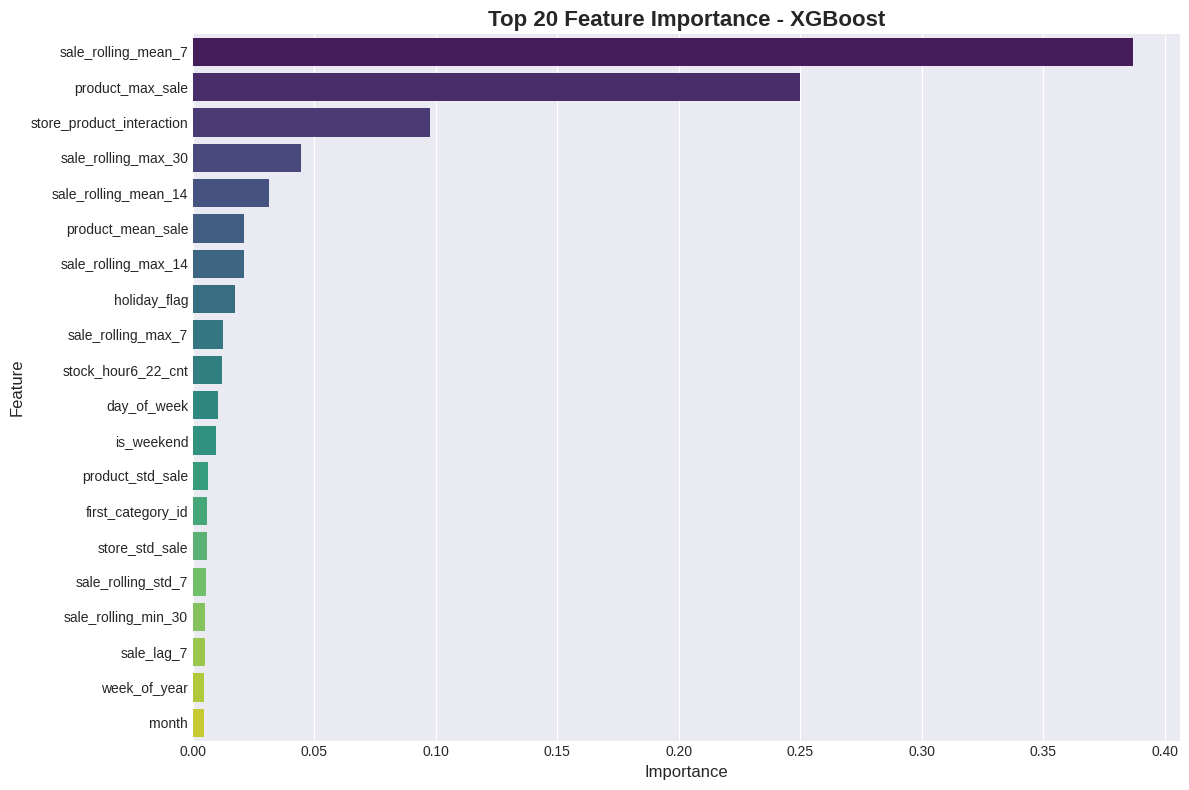

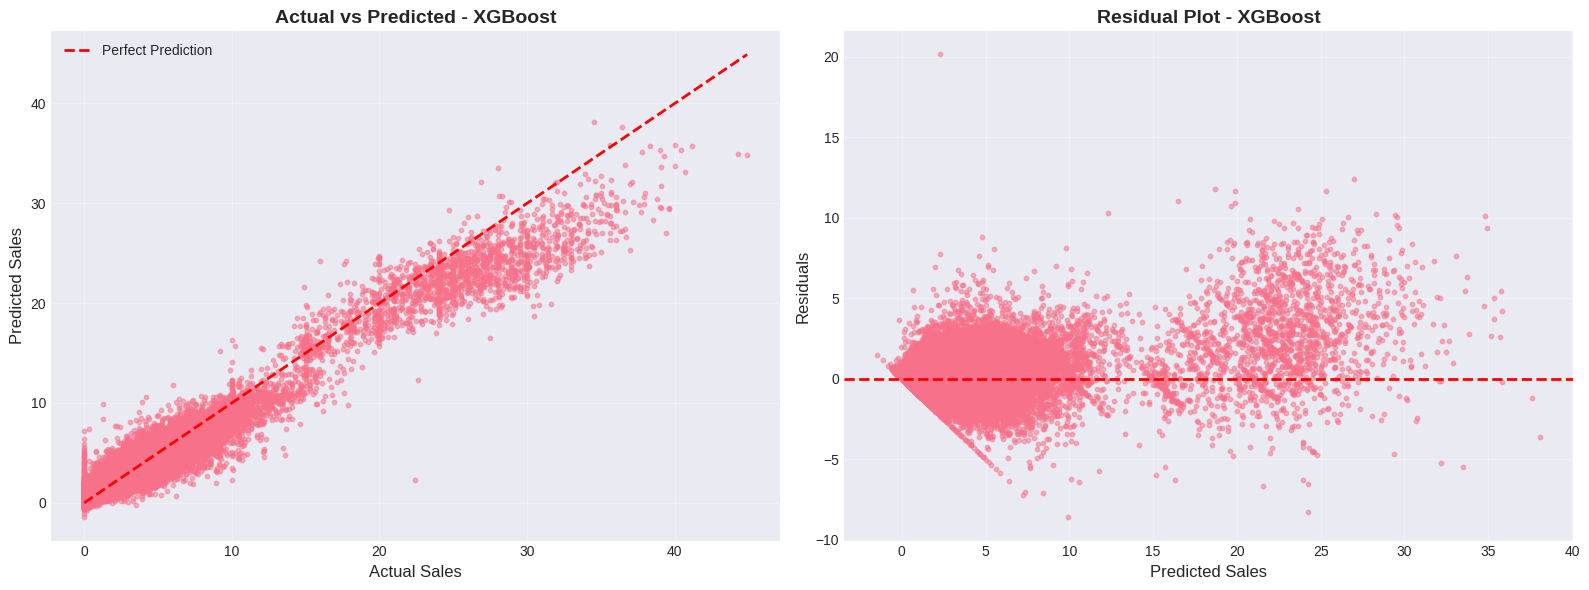

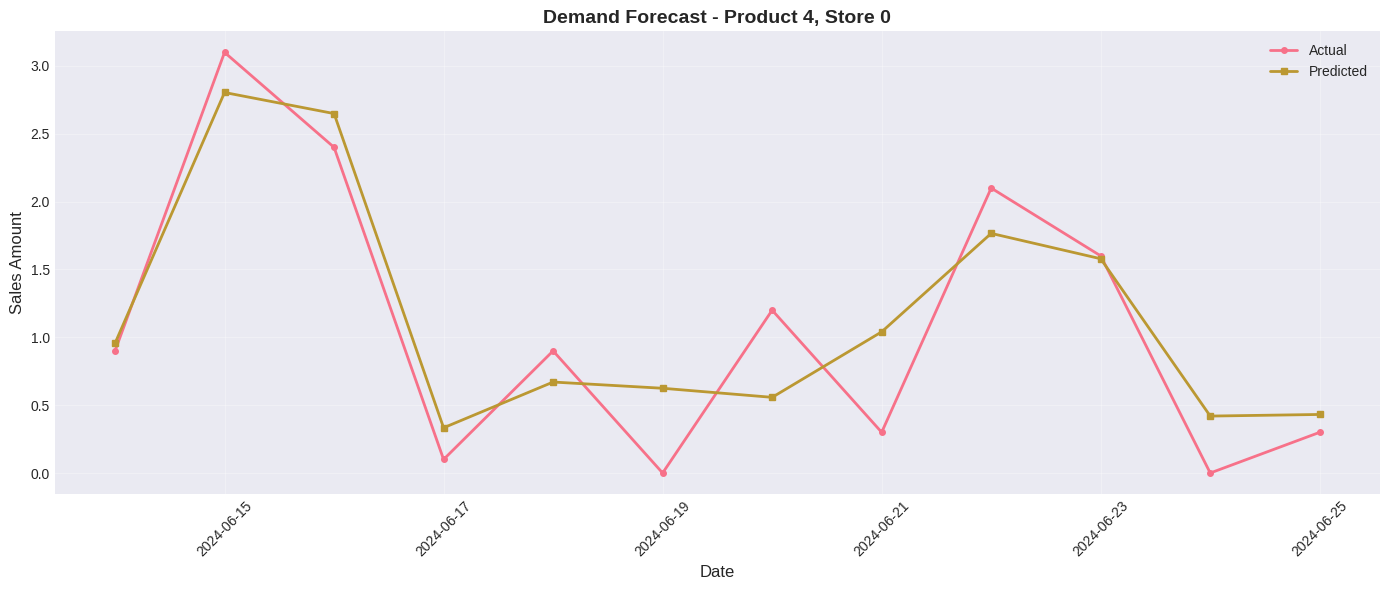

In [ ]:
# Visualizations
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

plot_feature_importance(best_model, feature_cols, best_name)
plot_predictions(y_test, best_pred, best_name)

# Select an example product_id and store_id from the test set
example_product_id = test_df['product_id'].iloc[0]
example_store_id = test_df['store_id'].iloc[0]

plot_time_series_forecast(test_df, y_test, best_pred, example_product_id, example_store_id)